## Final Project Submission

Please fill out:
* Student name: Beatrix Wong
* Student pace: flex
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


### Data Preperation

##### Importing and brief look at the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data= pd.read_csv('data/kc_house_data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

##### Converting 'grade' and 'condition' into numerical values

In [6]:
set(data['grade'])

{'10 Very Good',
 '11 Excellent',
 '12 Luxury',
 '13 Mansion',
 '3 Poor',
 '4 Low',
 '5 Fair',
 '6 Low Average',
 '7 Average',
 '8 Good',
 '9 Better'}

In [7]:
# turning grade into a number
data['grade_ind']= data['grade'].map(lambda x: int(x.split()[0]))

In [8]:
set(data['condition'])

{'Average', 'Fair', 'Good', 'Poor', 'Very Good'}

In [9]:
#encode condition into numbers, column= 'cond_ind'
cond_map = dict(zip(['Poor','Fair','Average','Good','Very Good'],range(1,6)))

In [10]:
data['cond_ind']=data['condition'].map(cond_map)

##### Filling in missing data- waterfront

In [11]:
data['waterfront'].describe()

count     19221
unique        2
top          NO
freq      19075
Name: waterfront, dtype: object

Looks like the vast majority of houses do not have a waterfront

In [12]:
#fill in null value with the mode
data['waterfront'].fillna('NO',inplace= True)
#include waterfront as binary variable
data['wtf_bin']=data['waterfront'].map({'NO':0,'YES':1})

### Data Analysis

In [13]:
# categorize the variables 
num_var= ['cond_ind','grade_ind','bedrooms','bathrooms','floors']
cont_var=['sqft_lot','sqft_living','price']
cat_var=['wtf_bin']

In [14]:
# Investigate correlations
data[num_var+cont_var+cat_var].corr()  

,cond_ind,grade_ind,bedrooms,bathrooms,floors,sqft_lot,sqft_living,price,wtf_bin
cond_ind,1.000000,-0.146896,0.026496,-0.126479,-0.264075,-0.008830,-0.059445,0.036056,0.016648
grade_ind,-0.146896,1.000000,0.356563,0.665838,0.458794,0.114731,0.762779,0.667951,0.082818
bedrooms,0.026496,0.356563,1.000000,0.514508,0.177944,0.032471,0.578212,0.308787,-0.002127
bathrooms,-0.126479,0.665838,0.514508,1.000000,0.502582,0.088373,0.755758,0.525906,0.063629
floors,-0.264075,0.458794,0.177944,0.502582,1.000000,-0.004814,0.353953,0.256804,0.020797
sqft_lot,-0.008830,0.114731,0.032471,0.088373,-0.004814,1.000000,0.173453,0.089876,0.021459
sqft_living,-0.059445,0.762779,0.578212,0.755758,0.353953,0.173453,1.000000,0.701917,0.104637
price,0.036056,0.667951,0.308787,0.525906,0.256804,0.089876,0.701917,1.000000,0.264306
wtf_bin,0.016648,0.082818,-0.002127,0.063629,0.020797,0.021459,0.104637,0.264306,1.000000


sqft_living is the most strongly correlated with price

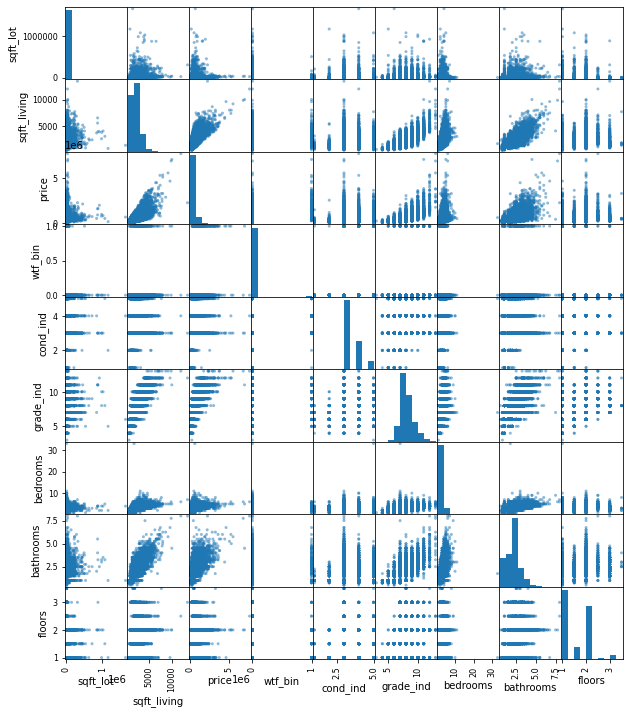

In [15]:
#investigate data distribution
pd.plotting.scatter_matrix(data[cont_var+cat_var+num_var], figsize=(10,12));

From looking at the graphs in the diagonals, the continuous variables looks very un-nomrally distributed, which violates the assumption of linear regression, I will create another set of data by transforming these variables to see if the resulting model would yield better results.

#### Transforming variables

In [17]:
import numpy as np

In [18]:
#log transform cont. variables, normalize the distribution
cont_log= pd.DataFrame([])
for c in cont_var:
    cont_log[c]= data[c].map(lambda x: np.log(x))

In [19]:
#normalize features
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
cont_log_scaled= cont_log.apply(normalize)

In [35]:
# new data set called ols_data to store transformed variables
ols_data= pd.concat([data.drop(cont_var, axis=1),cont_log_scaled], axis=1)

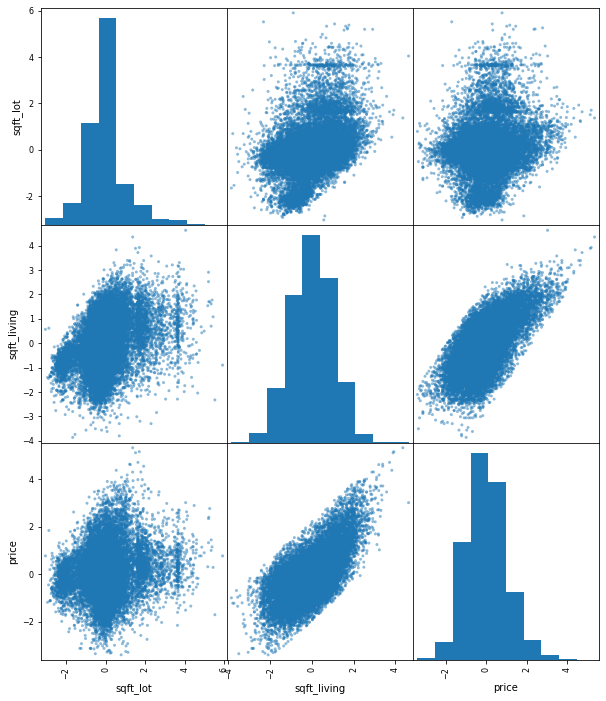

In [20]:
pd.plotting.scatter_matrix(cont_log_scaled, figsize=(10,12));

After transforming the variables, they seem a lot more normally distributed

#### Arriving at a Baseline Model
For the baseline model, I will do a simple linear regression using the dependent variable that is the most strongly correlated with price- sqft_living
I will run two models- one with the untransformed variable and the other with the transformed (normalised) version, and see which one yields better results.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [24]:
# untransformed sqft_lot as baseline
baselineI = LinearRegression()
r2I = cross_val_score(baselineI, data[['sqft_living']], data['price'], cv=5)
r2I.mean()

0.49092934612327843

In [28]:
#r2 value of baseline after log and normalization
baseline_trans= LinearRegression()
base_r2 = cross_val_score(baseline_trans,cont_log_scaled[['sqft_living']], cont_log_scaled[['price']], cv=5, scoring='r2')
base_r2.mean()

0.45331755286828307

Since the untransformed basline model has a better R2 score, I will use that as my baseline model.
#### The Baseline Model

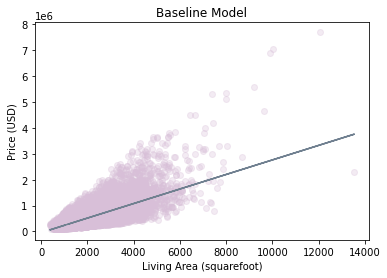

In [228]:
baselineI.fit(data[['sqft_living']],data['price'])
plt.scatter(data['sqft_living'], data['price'], color= 'thistle', alpha=0.3)
plt.plot(data['sqft_living'],baselineI.predict(data[['sqft_living']]), color= 'slategrey')
plt.title('Baseline Model')
plt.ylabel('Price (USD)')
plt.xlabel('Living Area (squarefoot)')
plt.savefig('baseline.png')
plt.show()


### Multiple Linear Regression

##### Model using original data

In [40]:
#r2 for original variables
or_lr= LinearRegression()
or_lr_r2= cross_val_score(or_lr, data[cont_var+num_var+cat_var].drop('price',axis=1), data['price'], cv=5).mean()
or_lr_r2

0.5874811697282899

##### Model Using normalised data

In [45]:
#cross val for linreg with transformed data
#check to see if r2 is bigger than untransformed 
linreg_I= LinearRegression()
cross_val_score(linreg_I, ols_data[cont_var+num_var+cat_var].drop('price',axis=1),ols_data['price'],cv=5,scoring='r2').mean() > or_lr_r2 

False

##### Model using one-hot encoding for categorical dependent variables (stored as num_var)

In [50]:
# model with num_var as categories, add dummy variable
dummy= pd.get_dummies(data=data[num_var].astype('str'), prefix=num_var, drop_first= True)

In [51]:
X=pd.concat([data.drop(num_var,axis=1),dummy],axis=1)[list(dummy.columns)+cat_var+cont_var].drop('price',axis=1)
y=data['price']

In [52]:
# model for linear regression
linreg_dum = LinearRegression()
cross_val_score(linreg_dum, X,y,cv=5).mean()
#shows that 80% of data points is poor at predicting the rest, bad model

-3174735508.236453

So far, the model that uses original data and treats the categorical variables as numbers yields the best results.

#### checking for colinearity

In [53]:
np.absolute(data[num_var].corr())>=0.75

,cond_ind,grade_ind,bedrooms,bathrooms,floors
cond_ind,True,False,False,False,False
grade_ind,False,True,False,False,False
bedrooms,False,False,True,False,False
bathrooms,False,False,False,True,False
floors,False,False,False,False,True


In [54]:
np.absolute(data[cont_var].corr()) >= 0.75

,sqft_lot,sqft_living,price
sqft_lot,True,False,False
sqft_living,False,True,False
price,False,False,True


Conclusion: no significant colinearity, no further action needed

In [56]:
#best r2 score so far:
or_lr_r2

0.5874811697282899

### The Final Model

In [46]:
#best model information
from statsmodels.formula.api import ols
outcome = 'price'
x_cols = num_var+cat_var+ ['sqft_living','sqft_lot']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data= data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     3901.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:52:27   Log-Likelihood:            -2.9773e+05
No. Observations:               21597   AIC:                         5.955e+05
Df Residuals:                   21588   BIC:                         5.956e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -7.24e+05   1.76e+04    -41.090      0.000   -7.59e+05    -6.9e+05
cond_ind     5.931e+04   2564.940     23.123      0.000    5.43e+04    6.43e+04
grade_ind    1.061e+05   2272.473     46.677      0.000    1.02e+05    1.11e+05
bedrooms    -3.866e+04   2201.663    -17.557      0.000    -4.3e+04   -3.43e+04
bathrooms   -1.156e+04   3525.074     -3.280      0.001   -1.85e+04   -4653.839
floors      -2.062e+04   3634.665     -5.674      0.000   -2.77e+04   -1.35e+04
wtf_bin      8.186e+05   1.97e+04     41.579      0.000     7.8e+05    8.57e+05
sqft_living   209.0878      3.498     59.766      0.000     202.231     215.945
sqft_lot       -0.3323      0.039     -8.417      0.000      -0.410      -0.255
==============================================================================
Omnibus:                    15280.876   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           794926.842
Skew:                           2.837   Prob(JB):                         0.00
Kurtosis:                      32.175   Cond. No.                     5.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model Discussion

After experienting with the baseline model, normalising the distribution of variables, 
and treating discrete variables categorically by one-hot encoding them, the model of untransformed 
indepedent variables yield the highest r2 score measured by cross-validation, meaning it is best able to 
account for the variability of the data points.
However, the data has a significant degree of positive skewness and kurtosis, the former
meaning the data is not normally distributed, with the median and mode higher than the mean, and the 
latter meaning there are many outliers that cannot be explained by the linear regression model. 
Moreover, the data violates the two assumptions of linear regression- homoscedasticity and normality,
which negatively impacts the reliability of the predictions.


### Three coefficients
Taking into acount the most significant coefficients and practicality when it comes to house rennovations, the three most useful variables are condition, grade, and squarefoot living respectively

In [96]:

variables= ['cond_ind', 'grade_ind', 'sqft_living']

To enhance the accuracy of the model, I will take the avergae of 5 train-test splits

In [128]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [146]:
X= data[cont_var+num_var+cat_var].drop('price',axis=1)
y= data['price']

In [147]:
X.columns

Index(['sqft_lot', 'sqft_living', 'cond_ind', 'grade_ind', 'bedrooms',
       'bathrooms', 'floors', 'wtf_bin'],
      dtype='object')

In [148]:
#avergae top 3 coefficients, R2, and y-intercept for the model
coef_cond_ls = []
coef_gr_ls=[]
coef_sql_ls=[]
inter_ls=[]
r2_ls=[]
for i in range(0,5):
    linreg= LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
    linreg.fit(X_train, y_train)
    coef_cond_ls.append(linreg.coef_[2])
    coef_gr_ls.append(linreg.coef_[3])
    coef_sql_ls.append(linreg.coef_[1])
    inter_ls.append(linreg.intercept_)
    r2_ls.append(r2_score(y_test, linreg.predict(X_test)))

In [149]:
r2= np.array(r2_ls).mean()
cond_coef= np.array(coef_cond_ls).mean()
grade_coef= np.array(coef_gr_ls).mean()
sqft_liv_coef= np.array(coef_sql_ls).mean()
intercept= np.array(inter_ls).mean()

In [99]:
var_co= [cond_coef, grade_coef,sqft_liv_coef]

In [ ]:
##### Model Summary

In [175]:

for i in range(0,3):
    print('For every unit increase in {}, the price increases by an average of {} dollars.'.format(titles[i], var_co[i].round(1)))
print('The y-intercept is {} dollars'.format(intercept.round(1)))

For every unit increase in building condition, the price increases by an average of 59472.8 dollars.
For every unit increase in building grade, the price increases by an average of 106323.2 dollars.
For every unit increase in squarefoot living area, the price increases by an average of 208.3 dollars.
The y-intercept is -726563.9 dollars


##### Visualisations
I have plotted graphs to show the correlation between the price and the three respective variables, and the predicted price according the the model coefficients.

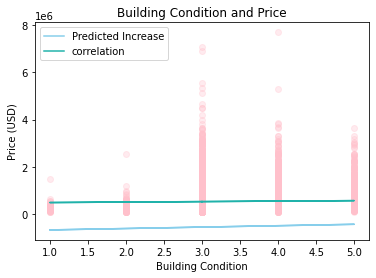

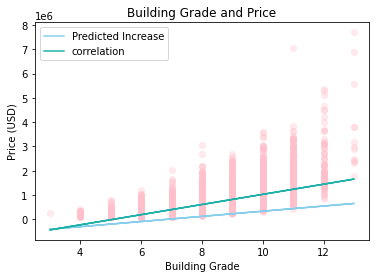

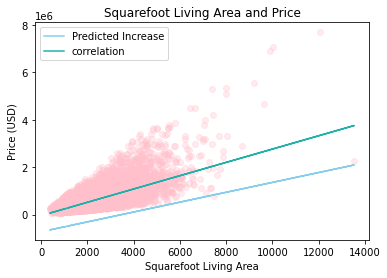

In [229]:
titles= ['Building Condition', 'Building Grade', 'Squarefoot Living Area']
for i,c in enumerate(variables):
    fig, ax= plt.subplots()
    x= data[variables[i]]
    yy= x*var_co[i] + intercept
    ax.plot(x,yy, color= 'skyblue', label= 'Predicted Increase')
    plt.scatter(data[c], data['price'], color ='pink', alpha= 0.3 )
    lrc= LinearRegression()
    lrc.fit( data[[variables[i]]], data['price'])
    ax.plot(x, lrc.predict(data[[variables[i]]]), color= 'lightseagreen', label= 'correlation')
    plt.title('{} and Price'.format(titles[i]))
    plt.xlabel(titles[i])
    plt.ylabel('Price (USD)')
    leg= ax.legend()
    plt.savefig('{}.png'.format(variables[i]))
    plt.show()

### Recommendations


#### Increase building condition
Building condition has to do with the maintenance of the house.
When doing rennovations, aim to increasing the life expectancy of the hosue upgrading old or deteriorating structures.  


#### Increase building grade

Building grade is related to the architecture and design of the house, both interior and exterior.
This includes the aesthetic of the architecture, and the quality of the material used in the building.
The basic requirement is to meet the building code, and the grade can be further increased by including custom designs and added amenities, such as:
* solid woods
* bathroom fixtures
* marble entry ways
* wood trim
* high quality cabinet work 

#### Increase squarefoot living area

Living area is the area of the house exlcuding the walls.
When rennovating, living area could be increased by removing walls or adding extra rooms.
